In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
%matplotlib inline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import SGDRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.metrics import mean_squared_error


In [2]:
#  Загрузка данных

data = pd.read_csv("datasets/happiness/data.csv")
data

,Country,happiness_score,gdp_per_capita,family,health,freedom,generosity,government_trust,dystopia_residual,continent,Year,social_support,cpi_score
0,Norway,7.5370,1.616463,1.533524,0.796667,0.635423,0.362012,0.315964,2.277027,Europe,2015,0.000000,88
1,Denmark,7.5220,1.482383,1.551122,0.792566,0.626007,0.355280,0.400770,2.313707,Europe,2015,0.000000,91
2,Iceland,7.5040,1.480633,1.610574,0.833552,0.627163,0.475540,0.153527,2.322715,Europe,2015,0.000000,79
3,Switzerland,7.4940,1.564980,1.516912,0.858131,0.620071,0.290549,0.367007,2.276716,Europe,2015,0.000000,86
4,Finland,7.4690,1.443572,1.540247,0.809158,0.617951,0.245483,0.382612,2.430182,Europe,2015,0.000000,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
787,Botswana,3.4789,0.997549,0.000000,0.494102,0.509089,0.033407,0.101786,0.257241,Africa,2020,1.085695,60
788,Tanzania,3.4762,0.457163,0.000000,0.442678,0.509343,0.271541,0.203881,0.718963,Africa,2020,0.872675,38
789,Rwanda,3.3123,0.343243,0.000000,0.572383,0.604088,0.235705,0.485542,0.548445,Africa,2020,0.522876,54
790,Zimbabwe,3.2992,0.425564,0.000000,0.375038,0.377405,0.151349,0.080929,0.841031,Africa,2020,1.047835,24


In [3]:
#  Удаление лишних атрибутов

data = data.drop("Year", axis=1)
data = data.drop("Country", axis=1)
data = data.drop("continent", axis=1)

In [4]:
#  Корреляция значений относительно показателя счастья

data.corr()["happiness_score"].sort_values(ascending=False)

happiness_score      1.000000
gdp_per_capita       0.793267
health               0.753534
cpi_score            0.693001
freedom              0.544284
government_trust     0.455477
social_support       0.192633
dystopia_residual    0.174161
generosity           0.155419
family               0.154946
Name: happiness_score, dtype: float64

array([[<AxesSubplot: xlabel='happiness_score', ylabel='happiness_score'>,
        <AxesSubplot: xlabel='gdp_per_capita', ylabel='happiness_score'>,
        <AxesSubplot: xlabel='freedom', ylabel='happiness_score'>,
        <AxesSubplot: xlabel='generosity', ylabel='happiness_score'>],
       [<AxesSubplot: xlabel='happiness_score', ylabel='gdp_per_capita'>,
        <AxesSubplot: xlabel='gdp_per_capita', ylabel='gdp_per_capita'>,
        <AxesSubplot: xlabel='freedom', ylabel='gdp_per_capita'>,
        <AxesSubplot: xlabel='generosity', ylabel='gdp_per_capita'>],
       [<AxesSubplot: xlabel='happiness_score', ylabel='freedom'>,
        <AxesSubplot: xlabel='gdp_per_capita', ylabel='freedom'>,
        <AxesSubplot: xlabel='freedom', ylabel='freedom'>,
        <AxesSubplot: xlabel='generosity', ylabel='freedom'>],
       [<AxesSubplot: xlabel='happiness_score', ylabel='generosity'>,
        <AxesSubplot: xlabel='gdp_per_capita', ylabel='generosity'>,
        <AxesSubplot: xlabel='freedo

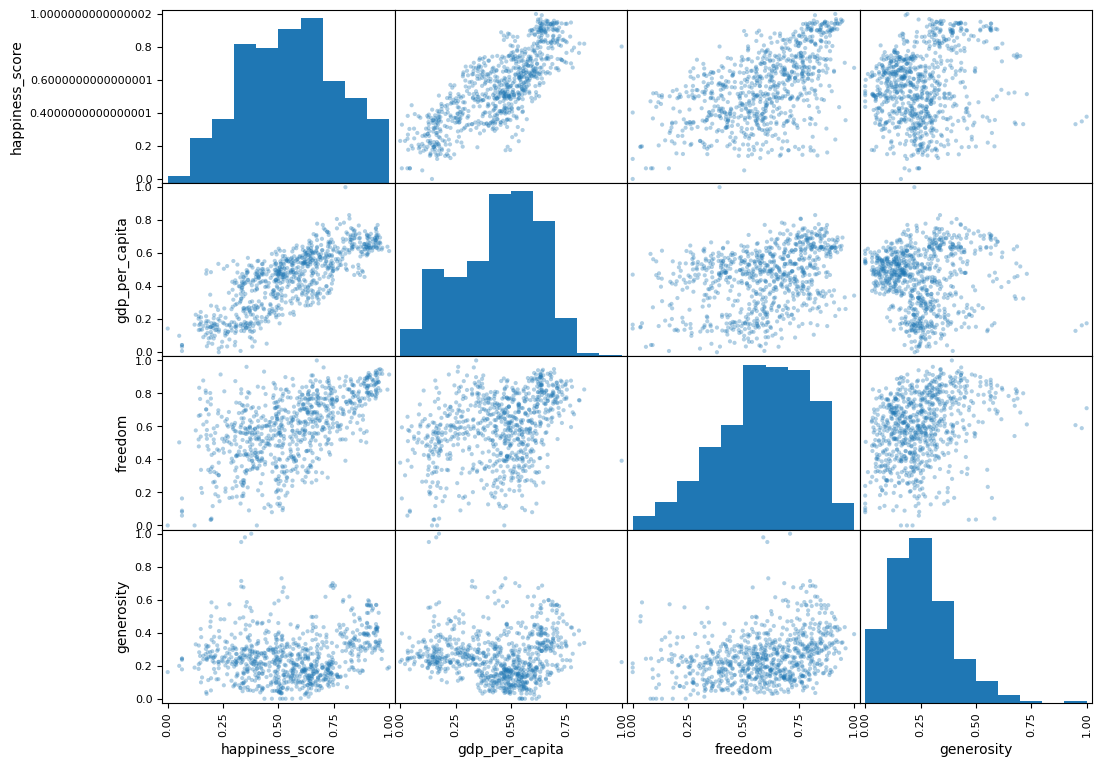

In [5]:
#  Нормализация значений (от 0 до 1)

MMS = MinMaxScaler(copy=True).fit(data)
data = MMS.transform(data)
data = pd.DataFrame(data, columns = ['happiness_score', 'gdp_per_capita',
                                     'family', 'health', 'freedom','generosity',
                                     'government_trust', 'dystopia_residual',
                                     'social_support','cpi_score'])

X = data.drop('happiness_score', axis=1)
y = data['happiness_score'].copy()

#  Деление на тренировочный и тестовый наборы
train_data, test_data, train_labels, test_labels  = train_test_split(X, y, test_size=0.2)

#  График зависимости показателя счастья от некоторых других
scatter_matrix(data[["happiness_score", "gdp_per_capita",
                     "freedom", "generosity"]], figsize=(12, 9), alpha=0.35)

In [6]:
#  Кривые обучения
def plot_learning_curves(model):
    X_train = train_data.values
    X_val = test_data.values
    y_train = train_labels.values
    y_val = test_labels.values
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors) , "r-+", linewidth=1, label="train")
    plt.plot(np.sqrt(val_errors) , "b-", linewidth=3, label="val")

Без кросс-валидации

Проверка на тренировочном наборе:

Прогнозы:  [0.31764566 0.99950664 0.62605635 0.74474301 0.68561833]
Ожидания:  [0.18087297728621693, 0.9525353362056024, 0.6335800565930398, 0.81233544357597, 0.6473157960410345]
Корень средней квадратичной ошибки:  0.08774605794557336 

Проверка на тестовом наборе:

Прогнозы:  [0.40792734 0.4534872  0.21744132 0.32568171 0.97570014]
Ожидания:  [0.5862680651610583, 0.48878246991209645, 0.21521232590620348, 0.3712655879681424, 0.931359483918661]
Корень средней квадратичной ошибки:  0.09006472895432815 

Кросс-валидация:
Средняя оценка:  0.08936522872333619 


	Кривые обучения:


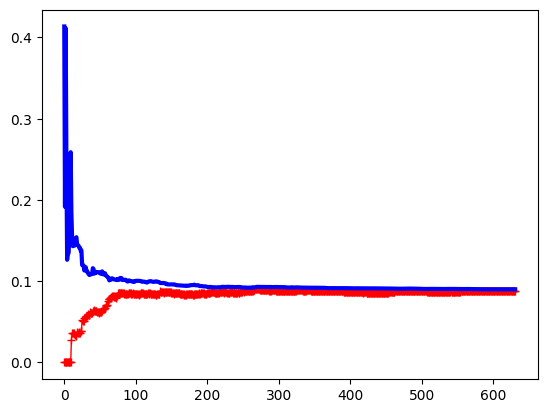

In [7]:
#  Линейная регрессия

#  Обучение без кросс-валидации
print("Без кросс-валидации\n")
LR = LinearRegression()
LR.fit(train_data, train_labels)

#  Оценка модели на тренировочном наборе с помощью RMSE
print("Проверка на тренировочном наборе:\n")
LR_predictions = LR.predict(train_data)
print("Прогнозы: ", LR_predictions[:5])
print("Ожидания: ", list(train_labels.values)[:5])
LR_rmse = np.sqrt(mean_squared_error(train_labels, LR_predictions))
print("Корень средней квадратичной ошибки: ", LR_rmse, '\n')

#  Оценка модели на тестовом наборе с помощью RMSE
print("Проверка на тестовом наборе:\n")
LR_predictions = LR.predict(test_data)
print("Прогнозы: ", LR_predictions[:5])
print("Ожидания: ", list(test_labels.values)[:5])
LR_rmse = np.sqrt(mean_squared_error(test_labels, LR_predictions))
print("Корень средней квадратичной ошибки: ", LR_rmse, '\n')

#  Обучение и оценка с кросс-валидацией на тренировочном наборе
print('Кросс-валидация:')
score = cross_val_score(LR, train_data, train_labels, scoring="neg_mean_squared_error", cv=10)
score = np.sqrt(-score)
print("Средняя оценка: ", score.mean(), '\n\n')

print("\tКривые обучения:")
plot_learning_curves(LR)

#  Не лучший результат => Модель плохо обучается/Модель не подходит для задачи

Проверка на тренировочном наборе:

Прогнозы:  [0.13909036 0.96427119 0.65216545 0.75219261 0.65618452]
Ожидания:  [0.18087297728621693, 0.9525353362056024, 0.6335800565930398, 0.81233544357597, 0.6473157960410345]
Корень средней квадратичной ошибки:  0.05631118415570823 

Проверка на тестовом наборе:

Прогнозы:  [0.42618974 0.47018643 0.23814131 0.37377289 0.95315859]
Ожидания:  [0.5862680651610583, 0.48878246991209645, 0.21521232590620348, 0.3712655879681424, 0.931359483918661]
Корень средней квадратичной ошибки:  0.06372322671198792 

Кросс-валидация:
Средняя оценка:  0.06090296647215996 


	Кривые обучения:


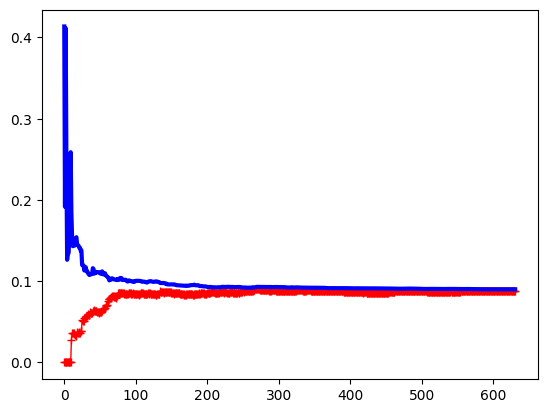

In [10]:
#  Полиномиальная регрессия

#  Создание полиномиальных признаков
poly_features = PolynomialFeatures(degree=2, include_bias=False)
train_data_poly = poly_features.fit_transform(train_data)
test_data_poly = poly_features.fit_transform(test_data)

# Обучение
LR_poly = LinearRegression()
LR_poly.fit(train_data_poly, train_labels)

#  Оценка модели на тренировочном наборе с помощью RMSE
print("Проверка на тренировочном наборе:\n")
LR_poly_predictions = LR_poly.predict(train_data_poly)
print("Прогнозы: ", LR_poly_predictions[:5])
print("Ожидания: ", list(train_labels.values)[:5])
LR_poly_rmse = np.sqrt(mean_squared_error(train_labels, LR_poly_predictions))
print("Корень средней квадратичной ошибки: ", LR_poly_rmse, '\n')

#  Оценка модели на тестовом наборе с помощью RMSE
print("Проверка на тестовом наборе:\n")
LR_poly_predictions = LR_poly.predict(test_data_poly)
print("Прогнозы: ", LR_poly_predictions[:5])
print("Ожидания: ", list(test_labels.values)[:5])
LR_poly_rmse = np.sqrt(mean_squared_error(test_labels, LR_poly_predictions))
print("Корень средней квадратичной ошибки: ", LR_poly_rmse, '\n')

#  Обучение и оценка с кросс-валидацией на тренировочном наборе
print('Кросс-валидация:')
score = cross_val_score(LR, train_data_poly, train_labels, scoring="neg_mean_squared_error", cv=10)
score = np.sqrt(-score)
print("Средняя оценка: ", score.mean(), '\n\n')

#  График процесса обучения
print("\tКривые обучения:")
plot_learning_curves(LR_poly)

#  Результат стал лучше
#  При степени >3 модель переобучается

Без кросс-валидации

Проверка на тренировочном наборе:

Прогнозы:  [0.21270442 0.6821295  0.49885271 0.45504345 0.47757319]
Ожидания:  [0.3050669547951684, 0.6659925770499675, 0.514155449084116, 0.5011827902470916, 0.33215690216128374]
Корень средней квадратичной ошибки:  0.06374707149706836 

Проверка на тестовом наборе:

Прогнозы:  [0.55819098 0.31508581 0.51901279 0.93620519 0.27013415]
Ожидания:  [0.4838223417780984, 0.13970392483893418, 0.5402914928420763, 0.931359483918661, 0.14220304896138475]
Корень средней квадратичной ошибки:  0.07721350364134708 

Кросс-валидация:
Средняя оценка:  0.06759403964966618 


	Кривые обучения:


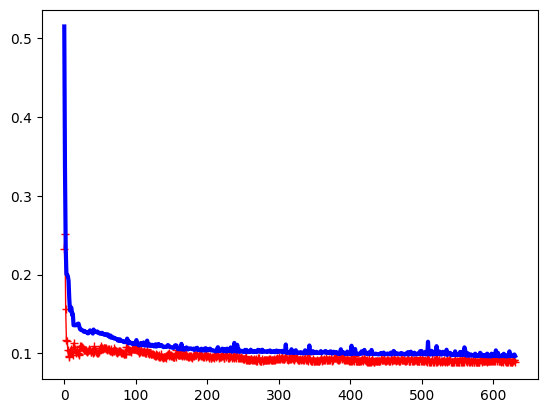

In [119]:
#  Полиномиальная регрессия со стохастическим градиентным спуском

#  Обучение без кросс-валидации
print("Без кросс-валидации\n")
SGDR = SGDRegressor(max_iter=99999999, penalty='l2', 
                    eta0=0.025, power_t=0, tol=0.03,
                    loss="squared_error"
                   )
SGDR.fit(train_data_poly, train_labels)

#  Оценка модели на тренировочном наборе с помощью RMSE
print("Проверка на тренировочном наборе:\n")
SGDR_predictions = SGDR.predict(train_data_poly)
print("Прогнозы: ", SGDR_predictions[:5])
print("Ожидания: ", list(train_labels.values)[:5])
SGDR_rmse = np.sqrt(mean_squared_error(train_labels, SGDR_predictions))
print("Корень средней квадратичной ошибки: ", SGDR_rmse, '\n')

#  Оценка модели на тестовом наборе с помощью RMSE
print("Проверка на тестовом наборе:\n")
SGDR_predictions = SGDR.predict(test_data_poly)
print("Прогнозы: ", SGDR_predictions[:5])
print("Ожидания: ", list(test_labels.values)[:5])
SGDR_rmse = np.sqrt(mean_squared_error(test_labels, SGDR_predictions))
print("Корень средней квадратичной ошибки: ", SGDR_rmse, '\n')

#  Обучение и оценка с кросс-валидацией на тренировочном наборе
print('Кросс-валидация:')
score = cross_val_score(SGDR, train_data_poly, train_labels, scoring="neg_mean_squared_error", cv=10)
score = np.sqrt(-score)
print("Средняя оценка: ", score.mean(), '\n\n')

#  График процесса обучения
print("\tКривые обучения:")
plot_learning_curves(SGDR)

#  Не лучше стандартной линейной регрессии 
#  Изменение параметров не сильно улучшает результат

Без кросс-валидации

Проверка на тренировочном наборе:

Прогнозы:  [0.30506695 0.66599258 0.51415545 0.50118279 0.3321569 ]
Ожидания:  [0.3050669547951684, 0.6659925770499675, 0.514155449084116, 0.5011827902470916, 0.33215690216128374]
Корень средней квадратичной ошибки:  5.08288248238951e-10 

Проверка на тестовом наборе:

Прогнозы:  [0.7381243  0.37527185 0.50080124 0.90428859 0.14634285]
Ожидания:  [0.4838223417780984, 0.13970392483893418, 0.5402914928420763, 0.931359483918661, 0.14220304896138475]
Корень средней квадратичной ошибки:  0.09371895028243522 

Кросс-валидация:
Средняя оценка:  0.09399752320310606 


	Кривые обучения:


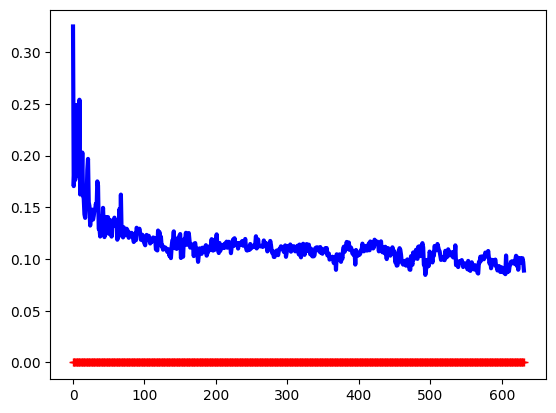

In [17]:
#  Дерево решений

#  Обучение без кросс-валидации
print("Без кросс-валидации\n")
DTR = DecisionTreeRegressor()
DTR.fit(train_data, train_labels)

#  Оценка модели на тренировочном наборе с помощью RMSE
print("Проверка на тренировочном наборе:\n")
DTR_predictions = DTR.predict(train_data)
print("Прогнозы: ", DTR_predictions[:5])
print("Ожидания: ", list(train_labels.values)[:5])
DTR_rmse = np.sqrt(mean_squared_error(train_labels, DTR_predictions))
print("Корень средней квадратичной ошибки: ", DTR_rmse, '\n')

#  Оценка модели на тестовом наборе с помощью RMSE
print("Проверка на тестовом наборе:\n")
DTR_predictions = DTR.predict(test_data)
print("Прогнозы: ", DTR_predictions[:5])
print("Ожидания: ", list(test_labels.values)[:5])
DTR_rmse = np.sqrt(mean_squared_error(test_labels, DTR_predictions))
print("Корень средней квадратичной ошибки: ", DTR_rmse, '\n')

#  Обучение и оценка с кросс-валидацией на тренировочном наборе
print('Кросс-валидация:')
score = cross_val_score(DTR, train_data, train_labels, scoring="neg_mean_squared_error", cv=10)
score = np.sqrt(-score)
print("Средняя оценка: ", score.mean(), '\n\n')

#  График процесса обучения
print("\tКривые обучения:")
plot_learning_curves(DTR)

#  Модель переобучается, требуется регуляризация гиперпараметров

In [6]:
#  Дерево решений, регуляризованное с использованием решётчатого поиска (вместе с кросс-валидацией)

# Гиперпараметры
hyperparams = [{'max_depth': [22, 23, 24, 25], 'min_samples_leaf': [2, 3, 4, 5],
               'min_samples_split': [2, 4, 6, 8], 'max_features': [6, 7, 8, 9],
               'max_leaf_nodes': [25, 26, 27, 28]}]

#  Обучение модели
DTR = DecisionTreeRegressor()
GS_DTR = GridSearchCV(DTR, hyperparams, cv=10, scoring='neg_mean_squared_error')
GS_DTR.fit(train_data, train_labels)
print("Лучший результат: ", np.sqrt(-GS_DTR.best_score_))

#  Оценка модели на тренировочном наборе с помощью RMSE
print("Проверка на тренировочном наборе:\n")
DTR_predictions = GS_DTR.best_estimator_.predict(train_data)
print("Прогнозы: ", DTR_predictions[:5])
print("Ожидания: ", list(train_labels.values)[:5])
DTR_rmse = np.sqrt(mean_squared_error(train_labels, DTR_predictions))
print("Корень средней квадратичной ошибки: ", DTR_rmse, '\n')

#  Оценка модели на тестовом наборе с помощью RMSE
print("Проверка на тестовом наборе:\n")
DTR_predictions = GS_DTR.best_estimator_.predict(test_data)
print("Прогнозы: ", DTR_predictions[:5])
print("Ожидания: ", list(test_labels.values)[:5])
DTR_rmse = np.sqrt(mean_squared_error(test_labels, DTR_predictions))
print("Корень средней квадратичной ошибки: ", DTR_rmse, '\n\n')

#  График процесса обучения
print("\tКривые обучения:")
plot_learning_curves(GS_DTR.best_estimator_)
GS_DTR.best_estimator_

#  Модель недообучается, возможно недостаточно данных
#  Использование решётчатого поиска тратит дополнительное время
#  на сравнение деревьев с разными гиперпараметрами

Лучший результат:  0.09007716200359871
Проверка на тренировочном наборе:

Прогнозы:  [0.64679397 0.58828676 0.54480648 0.25882033 0.81365641]
Ожидания:  [0.6785455529592528, 0.5940898056800554, 0.6087794159230495, 0.3487542372061511, 0.8071845412829721]
Корень средней квадратичной ошибки:  0.07364835567422619 

Проверка на тестовом наборе:

Прогнозы:  [0.67227436 0.48599353 0.25882033 0.25882033 0.48442679]
Ожидания:  [0.6302987444921759, 0.4016749885311823, 0.17705749410621846, 0.3586744934741474, 0.5044259509500904]
Корень средней квадратичной ошибки:  0.09752663786245316 


	Кривые обучения:


NameError: name 'plot_learning_curves' is not defined

Проверка на тренировочном наборе:

Прогнозы:  [0.25310236 0.65879809 0.44405547 0.48894113 0.38847342]
Ожидания:  [0.3050669547951684, 0.6659925770499675, 0.514155449084116, 0.5011827902470916, 0.33215690216128374]
Корень средней квадратичной ошибки:  0.04895174814042977 

Проверка на тестовом наборе:

Прогнозы:  [0.63082894 0.27102154 0.4812122  0.88540785 0.21092627]
Ожидания:  [0.4838223417780984, 0.13970392483893418, 0.5402914928420763, 0.931359483918661, 0.14220304896138475]
Корень средней квадратичной ошибки:  0.07271461667399857 


Кросс-валидация:
Средняя оценка:  0.07124060869389451 


	Кривые обучения:


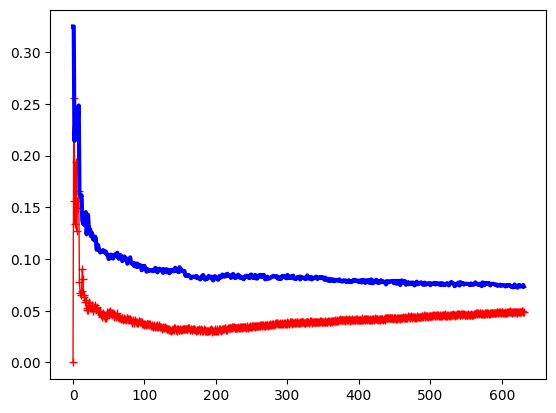

In [137]:
#  Дерево принятия решений с ансамблевым обучением (Адаптивным бустингом)
#  после регуляризации

#  Обучение модели
ABR = AdaBoostRegressor(GS_DTR.best_estimator_, n_estimators=100, learning_rate=0.1, loss='square')
ABR.fit(train_data, train_labels)


#  Оценка модели на тренировочном наборе с помощью RMSE
print("Проверка на тренировочном наборе:\n")
ABR_predictions = ABR.predict(train_data)
print("Прогнозы: ", ABR_predictions[:5])
print("Ожидания: ", list(train_labels.values)[:5])
ABR_rmse = np.sqrt(mean_squared_error(train_labels, ABR_predictions))
print("Корень средней квадратичной ошибки: ", ABR_rmse, '\n')

#  Оценка модели на тестовом наборе с помощью RMSE
print("Проверка на тестовом наборе:\n")
ABR_predictions = ABR.predict(test_data)
print("Прогнозы: ", ABR_predictions[:5])
print("Ожидания: ", list(test_labels.values)[:5])
ABR_rmse = np.sqrt(mean_squared_error(test_labels, ABR_predictions))
print("Корень средней квадратичной ошибки: ", ABR_rmse, '\n\n')

#  Обучение и оценка с кросс-валидацией на тренировочном наборе
print('Кросс-валидация:')
score = cross_val_score(ABR, train_data, train_labels, scoring="neg_mean_squared_error", cv=10)
score = np.sqrt(-score)
print("Средняя оценка: ", score.mean(), '\n\n')

#  График процесса обучения
print("\tКривые обучения:")
plot_learning_curves(ABR)

#  Модель обобщается лучше, но всё равно недообучается
#  Использование ансамблевых методов так же повышает время, необходимое для обучения

In [130]:
#  Случайный лес с решётчатым поиском и ансамблевым обучением (Адаптивным бустингом)

#  Обучение
ABR = AdaBoostRegressor(GS_RDR.best_estimator_, n_estimators=100, learning_rate=0.1, loss='square')
ABR.fit(train_data, train_labels)

#  Оценка модели на тренировочном наборе с помощью RMSE
print("Проверка на тренировочном наборе:\n")
ABR_predictions = ABR.predict(train_data)
print("Прогнозы: ", ABR_predictions[:5])
print("Ожидания: ", list(train_labels.values)[:5])
ABR_rmse = np.sqrt(mean_squared_error(train_labels, ABR_predictions))
print("Корень средней квадратичной ошибки: ", ABR_rmse, '\n')

#  Оценка модели на тестовом наборе с помощью RMSE
print("Проверка на тестовом наборе:\n")
ABR_predictions = ABR.predict(test_data)
print("Прогнозы: ", ABR_predictions[:5])
print("Ожидания: ", list(test_labels.values)[:5])
ABR_rmse = np.sqrt(mean_squared_error(test_labels, ABR_predictions))
print("Корень средней квадратичной ошибки: ", ABR_rmse, '\n')

#  Обучение и оценка с кросс-валидацией на тренировочном наборе
print('Кросс-валидация:')
score = cross_val_score(ABR, train_data, train_labels, scoring="neg_mean_squared_error", cv=10)
score = np.sqrt(-score)
print("Средняя оценка: ", score.mean(), '\n')

# Модель переобучается сильнее

Проверка на тренировочном наборе:

Прогнозы:  [0.28560761 0.66166812 0.49390401 0.49842076 0.35132474]
Ожидания:  [0.3050669547951684, 0.6659925770499675, 0.514155449084116, 0.5011827902470916, 0.33215690216128374]
Корень средней квадратичной ошибки:  0.017111690484544795 

Проверка на тестовом наборе:

Прогнозы:  [0.6202045  0.28126979 0.494727   0.9118917  0.18854324]
Ожидания:  [0.4838223417780984, 0.13970392483893418, 0.5402914928420763, 0.931359483918661, 0.14220304896138475]
Корень средней квадратичной ошибки:  0.0641406879171767 

Кросс-валидация:
Средняя оценка:  0.06275903613896565 



Решётчатый поиск и кросс-валидация: 

Лучший результат:  0.06444351371681031
Проверка на тренировочном наборе:

Прогнозы:  [0.94753232 0.21150406 0.29423098 0.64755312 0.35822617]
Ожидания:  [0.957705352733913, 0.21521232590620348, 0.2606165757481857, 0.6534205691290322, 0.3300583696241585]
Корень средней квадратичной ошибки:  0.024108543950833578 

Проверка на тестовом наборе:

Прогнозы:  [0.92259451 0.49347056 0.55353313 0.66848276 0.56726314]
Ожидания:  [0.9590407718469127, 0.4819146001880991, 0.5112938206740878, 0.6302987444921759, 0.5257926567580822]
Корень средней квадратичной ошибки:  0.06334780055786716 


	Кривые обучения:


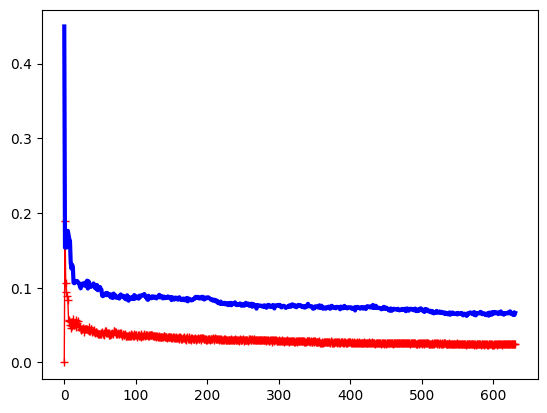

In [12]:
#  Метод случайного леса с решётчатым поиском (вместе с кросс-валидацией)

#  Гиперпараметры
hyperparams = [
    {'n_estimators': [2, 4, 10, 20, 50, 100] , 'max_features': [2, 4, 6, 8, 9, 12, 16]}
]

#  Обучение и оценка
print("Решётчатый поиск и кросс-валидация: \n")
RDR = RandomForestRegressor()
GS_RDR = GridSearchCV(RDR, hyperparams, cv=10, scoring='neg_mean_squared_error')
GS_RDR.fit(train_data, train_labels)
print("Лучший результат: ", np.sqrt(-GS_RDR.best_score_))

#  Оценка модели на тренировочном наборе с помощью RMSE
print("Проверка на тренировочном наборе:\n")
GS_RDR_predictions = GS_RDR.best_estimator_.predict(train_data)
print("Прогнозы: ", GS_RDR_predictions[:5])
print("Ожидания: ", list(train_labels.values)[:5])
GS_RDR_rmse = np.sqrt(mean_squared_error(train_labels, GS_RDR_predictions))
print("Корень средней квадратичной ошибки: ", GS_RDR_rmse, '\n')

#  Оценка модели на тестовом наборе с помощью RMSE
print("Проверка на тестовом наборе:\n")
GS_RDR_predictions = GS_RDR.best_estimator_.predict(test_data)
print("Прогнозы: ", GS_RDR_predictions[:5])
print("Ожидания: ", list(test_labels.values)[:5])
GS_RDR_rmse = np.sqrt(mean_squared_error(test_labels, GS_RDR_predictions))
print("Корень средней квадратичной ошибки: ", GS_RDR_rmse, '\n\n')

#  График процесса обучения
print("\tКривые обучения:")
plot_learning_curves(GS_RDR.best_estimator_)

#  Результат не изменился

Рандомизированный поиск и кросс-валидация: 

Лучший результат:  0.06687114135646972
Проверка на тренировочном наборе:

Прогнозы:  [0.52295518 0.56433838 0.47722895 0.5049975  0.54416771]
Ожидания:  [0.5275096241890813, 0.5563165221980702, 0.49946582281609225, 0.5038536284730906, 0.5153000780130861]
Корень средней квадратичной ошибки:  0.02522180300132976 

Проверка на тестовом наборе:

Прогнозы:  [0.68269895 0.39414914 0.30276715 0.61621728 0.34923546]
Ожидания:  [0.6965355290630153, 0.3334923153602843, 0.20910755281820587, 0.5628028436040677, 0.4352512630265198]
Корень средней квадратичной ошибки:  0.06230465900993596 


	Кривые обучения:


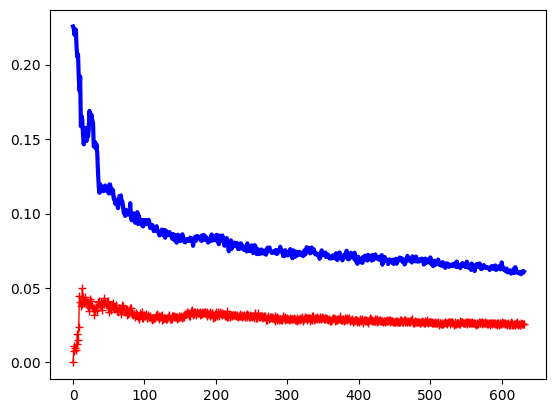

In [25]:
#  Метод случайного леса с рандомизированным поиском (вместе с кросс-валидацией)

#  Гиперпараметры
hyperparams = [
    {'n_estimators': [i for i in range(1, 200)] , 'max_features': [i for i in range(1, 50)]}
]

#  Обучение и оценка
print("Рандомизированный поиск и кросс-валидация: \n")
RDR = RandomForestRegressor()
RS_RDR = RandomizedSearchCV(RDR, hyperparams, n_iter=20, cv=10, scoring='neg_mean_squared_error')
RS_RDR.fit(train_data, train_labels)
print("Лучший результат: ", np.sqrt(-RS_RDR.best_score_))

#  Оценка модели на тренировочном наборе с помощью RMSE
print("Проверка на тренировочном наборе:\n")
RS_RDR_predictions = RS_RDR.best_estimator_.predict(train_data)
print("Прогнозы: ", RS_RDR_predictions[:5])
print("Ожидания: ", list(train_labels.values)[:5])
RS_RDR_rmse = np.sqrt(mean_squared_error(train_labels, RS_RDR_predictions))
print("Корень средней квадратичной ошибки: ", RS_RDR_rmse, '\n')

#  Оценка модели на тестовом наборе с помощью RMSE
print("Проверка на тестовом наборе:\n")
RS_RDR_predictions = RS_RDR.best_estimator_.predict(test_data)
print("Прогнозы: ", RS_RDR_predictions[:5])
print("Ожидания: ", list(test_labels.values)[:5])
RS_RDR_rmse = np.sqrt(mean_squared_error(test_labels, RS_RDR_predictions))
print("Корень средней квадратичной ошибки: ", RS_RDR_rmse, '\n\n')

#  График процесса обучения
print("\tКривые обучения:")
plot_learning_curves(RS_RDR.best_estimator_)

#  Результат не изменился

Проверка на тренировочном наборе:

Прогнозы:  [0.54570537 0.55794286 0.45963293 0.52133737 0.50313354]
Ожидания:  [0.5275096241890813, 0.5563165221980702, 0.49946582281609225, 0.5038536284730906, 0.5153000780130861]
Корень средней квадратичной ошибки:  0.06876929213896402 

Проверка на тестовом наборе:

Прогнозы:  [0.6677449  0.34017681 0.34682314 0.5540945  0.51491814]
Ожидания:  [0.6965355290630153, 0.3334923153602843, 0.20910755281820587, 0.5628028436040677, 0.4352512630265198]
Корень средней квадратичной ошибки:  0.0732060715454051 

Кросс-валидация:
Средняя оценка:  0.07404940636083264 

	Кривые обучения:


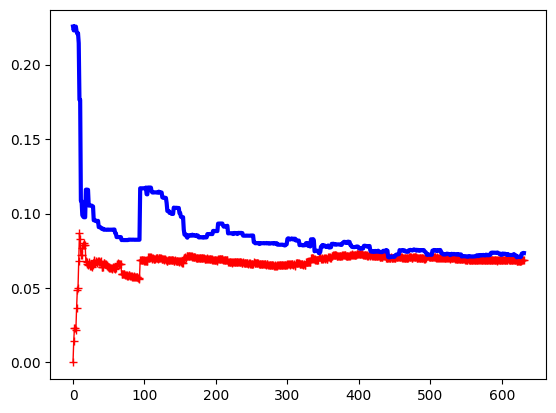

In [28]:
#  Метод опорных векторов

#  Обучение
svr = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
svr.fit(train_data, train_labels)

#  Оценка модели на тренировочном наборе с помощью RMSE
print("Проверка на тренировочном наборе:\n")
svr_predictions = svr.predict(train_data)
print("Прогнозы: ", svr_predictions[:5])
print("Ожидания: ", list(train_labels.values)[:5])
svr_rmse = np.sqrt(mean_squared_error(train_labels, svr_predictions))
print("Корень средней квадратичной ошибки: ", svr_rmse, '\n')

#  Оценка модели на тестовом наборе с помощью RMSE
print("Проверка на тестовом наборе:\n")
svr_predictions = svr.predict(test_data)
print("Прогнозы: ", svr_predictions[:5])
print("Ожидания: ", list(test_labels.values)[:5])
svr_rmse = np.sqrt(mean_squared_error(test_labels, svr_predictions))
print("Корень средней квадратичной ошибки: ", svr_rmse, '\n')

#  Обучение и оценка с кросс-валидацией на тренировочном наборе
print('Кросс-валидация:')
score = cross_val_score(svr, train_data, train_labels, scoring="neg_mean_squared_error", cv=10)
score = np.sqrt(-score)
print("Средняя оценка: ", score.mean(), '\n')

#  График процесса обучения
print("\tКривые обучения:")
plot_learning_curves(svr)

#  Модель недообучается

In [29]:
#  Градиентный бустинг

#  Обучение
GB = GradientBoostingRegressor(max_depth=2, n_estimators=3000, learning_rate=0.01, subsample=0.25)
GB.fit(train_data, train_labels)

#  Оценка модели на тренировочном наборе с помощью RMSE
print("Проверка на тренировочном наборе:\n")
GB_predictions = GB.predict(train_data)
print("Прогнозы: ", GB_predictions[:5])
print("Ожидания: ", list(train_labels.values)[:5])
GB_rmse = np.sqrt(mean_squared_error(train_labels, GB_predictions))
print("Корень средней квадратичной ошибки: ", GB_rmse, '\n')

#  Оценка модели на тестовом наборе с помощью RMSE
print("Проверка на тестовом наборе:\n")
GB_predictions = GB.predict(test_data)
print("Прогнозы: ", GB_predictions[:5])
print("Ожидания: ", list(test_labels.values)[:5])
GB_rmse = np.sqrt(mean_squared_error(test_labels, GB_predictions))
print("Корень средней квадратичной ошибки: ", GB_rmse, '\n')

#  Обучение и оценка с кросс-валидацией на тренировочном наборе
print('Кросс-валидация:')
score = cross_val_score(GB, train_data, train_labels, scoring="neg_mean_squared_error", cv=10)
score = np.sqrt(-score)
print("Средняя оценка: ", score.mean(), '\n')

#  Модель обобщается лучшего всего

Проверка на тренировочном наборе:

Прогнозы:  [0.51415161 0.58666259 0.47198757 0.49577065 0.54116915]
Ожидания:  [0.5275096241890813, 0.5563165221980702, 0.49946582281609225, 0.5038536284730906, 0.5153000780130861]
Корень средней квадратичной ошибки:  0.03498468341931318 

Проверка на тестовом наборе:

Прогнозы:  [0.70777259 0.33018476 0.34009902 0.59645889 0.41292276]
Ожидания:  [0.6965355290630153, 0.3334923153602843, 0.20910755281820587, 0.5628028436040677, 0.4352512630265198]
Корень средней квадратичной ошибки:  0.05362836945859794 

Кросс-валидация:
Средняя оценка:  0.06002927988633185 



In [19]:
# Уменьшение размерности с сохранением 95% дисперсии данных

pca = PCA(n_components=0.95)
train_data_PCA = pca.fit_transform(train_data)
test_data_PCA = pca.fit_transform(test_data)

In [126]:
#  Дерево принятия решений с ансамблевым обучением (Адаптивным бустингом) 
#  и решётчатым поиском на данных с уменьшенной размерностью

#  Гиперпараметры
hyperparams = [{'max_depth': [18, 19, 20, 21], 'min_samples_leaf': [2, 3, 4, 5, 6],
               'min_samples_split': [2, 3, 4], 'max_features': [4, 5, 6],
               'max_leaf_nodes': [38, 39, 40]}]

#  Обучение
DTR = DecisionTreeRegressor()
GS_DTR_PCA = GridSearchCV(DTR, hyperparams, cv=10)
GS_DTR_PCA.fit(train_data_PCA, train_labels)
ABR = AdaBoostRegressor(GS_DTR_PCA.best_estimator_, n_estimators=100, learning_rate=0.01, loss='square')
ABR.fit(train_data_PCA, train_labels)

#  Оценка модели на тренировочном наборе с помощью RMSE
print("Проверка на тренировочном наборе:\n")
ABR_predictions = ABR.predict(train_data_PCA)
print("Прогнозы: ", ABR_predictions[:5])
print("Ожидания: ", list(train_labels.values)[:5])
ABR_rmse = np.sqrt(mean_squared_error(train_labels, ABR_predictions))
print("Корень средней квадратичной ошибки: ", ABR_rmse, '\n')

#  Оценка модели на тестовом наборе с помощью RMSE
print("Проверка на тестовом наборе:\n")
ABR_predictions = ABR.predict(test_data_PCA)
print("Прогнозы: ", ABR_predictions[:5])
print("Ожидания: ", list(test_labels.values)[:5])
ABR_rmse = np.sqrt(mean_squared_error(test_labels, ABR_predictions))
print("Корень средней квадратичной ошибки: ", ABR_rmse, '\n')

#  Модель хуже обощается после уменьшения размерночти данных

Проверка на тренировочном наборе:

Прогнозы:  [0.24998217 0.65700059 0.49591742 0.41999574 0.37522098]
Ожидания:  [0.3050669547951684, 0.6659925770499675, 0.514155449084116, 0.5011827902470916, 0.33215690216128374]
Корень средней квадратичной ошибки:  0.04845910280898717 

Проверка на тестовом наборе:

Прогнозы:  [0.69836433 0.34841508 0.51159634 0.8949887  0.66403942]
Ожидания:  [0.4838223417780984, 0.13970392483893418, 0.5402914928420763, 0.931359483918661, 0.14220304896138475]
Корень средней квадратичной ошибки:  0.12745661180712248 



In [17]:
#  Регрессия с голосованием с использованием лучших моделей

#  Модели
reg1 = SGDRegressor(max_iter=99999999, penalty='l2', eta0=0.025, power_t=0, tol=0.03, loss="squared_error")
reg2 = AdaBoostRegressor(GS_DTR.best_estimator_, n_estimators=100, learning_rate=0.1, loss='square')
reg3 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
reg4 = GradientBoostingRegressor(max_depth=2, n_estimators=3000, learning_rate=0.01, subsample=0.25)

#  Обучение
VR = VotingRegressor(estimators=[('lr', reg1), ('dt', reg2), ('svr', reg3), ('gd', reg4)])
VR.fit(train_data, train_labels)

#  Оценка модели на тренировочном наборе с помощью RMSE
print("Проверка на тренировочном наборе:\n")
VR_predictions = VR.predict(train_data)
print("Прогнозы: ", VR_predictions[:5])
print("Ожидания: ", list(train_labels.values)[:5])
VR_rmse = np.sqrt(mean_squared_error(train_labels, VR_predictions))
print("Корень средней квадратичной ошибки: ", VR_rmse, '\n')

#  Оценка модели на тестовом наборе с помощью RMSE
print("Проверка на тестовом наборе:\n")
VR_predictions = VR.predict(test_data)
print("Прогнозы: ", VR_predictions[:5])
print("Ожидания: ", list(test_labels.values)[:5])
VR_rmse = np.sqrt(mean_squared_error(test_labels, VR_predictions))
print("Корень средней квадратичной ошибки: ", VR_rmse, '\n')

#  Обучение и оценка с кросс-валидацией на тренировочном наборе
print('Кросс-валидация:')
score = cross_val_score(VR, train_data, train_labels, scoring="neg_mean_squared_error", cv=10)
score = np.sqrt(-score)
print("Средняя оценка: ", score.mean(), '\n')

#  Средний результат

Проверка на тренировочном наборе:

Прогнозы:  [0.92611878 0.24978819 0.2623451  0.61698811 0.38284074]
Ожидания:  [0.957705352733913, 0.21521232590620348, 0.2606165757481857, 0.6534205691290322, 0.3300583696241585]
Корень средней квадратичной ошибки:  0.05127938266138475 

Проверка на тестовом наборе:

Прогнозы:  [0.89193384 0.52619371 0.59047786 0.71642699 0.57787595]
Ожидания:  [0.9590407718469127, 0.4819146001880991, 0.5112938206740878, 0.6302987444921759, 0.5257926567580822]
Корень средней квадратичной ошибки:  0.06663277992350355 

Кросс-валидация:
Средняя оценка:  0.06345635923616719 



In [20]:
#  Регрессия с голосованием на данных
#  с уменьшенной размерностью

#  Модели
reg1 = SGDRegressor(max_iter=99999999, penalty='l2', eta0=0.025, power_t=0, tol=0.03, loss="squared_error")
reg2 = AdaBoostRegressor(GS_DTR.best_estimator_, n_estimators=100, learning_rate=0.1, loss='square')
reg3 = SVR(kernel="poly", degree=2, C=100, epsilon=0.1)
reg4 = GradientBoostingRegressor(max_depth=2, n_estimators=3000, learning_rate=0.01, subsample=0.25)

#  Обучение
VR = VotingRegressor(estimators=[('sgdr', reg1), ('dt', reg2), ('svr', reg3), ('gd', reg4)])
VR.fit(train_data_PCA, train_labels)

#  Оценка модели на тренировочном наборе с помощью RMSE
print("Проверка на тренировочном наборе:\n")
VR_predictions = VR.predict(train_data_PCA)
print("Прогнозы: ", VR_predictions[:5])
print("Ожидания: ", list(train_labels.values)[:5])
VR_rmse = np.sqrt(mean_squared_error(train_labels, VR_predictions))
print("Корень средней квадратичной ошибки: ", VR_rmse, '\n')

#  Оценка модели на тестовом наборе с помощью RMSE
print("Проверка на тестовом наборе:\n")
VR_predictions = VR.predict(test_data_PCA)
print("Прогнозы: ", VR_predictions[:5])
print("Ожидания: ", list(test_labels.values)[:5])
VR_rmse = np.sqrt(mean_squared_error(test_labels, VR_predictions))
print("Корень средней квадратичной ошибки: ", VR_rmse, '\n')

#  Обучение и оценка с кросс-валидацией на тренировочном наборе
print('Кросс-валидация:')
score = cross_val_score(VR, train_data_PCA, train_labels, scoring="neg_mean_squared_error", cv=10)
score = np.sqrt(-score)
print("Средняя оценка: ", score.mean(), '\n')

#  Модель хуже обощается после уменьшения размерности данных

Проверка на тренировочном наборе:

Прогнозы:  [0.88154232 0.22432556 0.31823575 0.57287131 0.35503769]
Ожидания:  [0.957705352733913, 0.21521232590620348, 0.2606165757481857, 0.6534205691290322, 0.3300583696241585]
Корень средней квадратичной ошибки:  0.05988078702264582 

Проверка на тестовом наборе:

Прогнозы:  [0.88357206 0.43914857 0.55704671 0.70435783 0.60354019]
Ожидания:  [0.9590407718469127, 0.4819146001880991, 0.5112938206740878, 0.6302987444921759, 0.5257926567580822]
Корень средней квадратичной ошибки:  0.08743809484659634 

Кросс-валидация:
Средняя оценка:  0.0725491075508879 

